In [24]:
!pip install keras==2.15 tensorflow==2.15 tensorflow_addons

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [26]:
tf.random.set_global_generator(tf.random.Generator.from_seed(seed=42))
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [27]:
df = pd.read_excel('/kaggle/input/local-beauty/Dataset.xlsx')
df['image name'] = '/kaggle/input/local-beauty/all images/all images/'+df['image name']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['gender']) # 30% of data go to df_test
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['gender']) # 15% valid and 15% testing

In [28]:
def load_data(im_path, label_score, label_gender, label_smile):
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [384, 384])
    return image, (label_score, label_gender, label_smile)


def create_dataset(df):
    im_paths = df['image name'].values.astype('str')
    labels_score = df['final rating'].values.astype('float32')
    labels_gender = df['gender'].values.astype('float32')
    labels_smile = df['Smile - non Smile'].values.astype('float32')
    dataset = tf.data.Dataset.from_tensor_slices((im_paths, labels_score, labels_gender, labels_smile))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    return  dataset

train_dataset = create_dataset(df_train)
valid_dataset = create_dataset(df_valid)
test_dataset = create_dataset(df_test)

batch_size=32
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [29]:
input_layer = layers.Input((384,384,3))
x = layers.RandomFlip(mode="horizontal")(input_layer)
model = tf.keras.applications.EfficientNetV2B1( 
    include_top=False,
    weights="imagenet",
    input_tensor = x, # x input_layer
    pooling='avg'
)

act='relu' # swish relu elu
x = layers.Dense(64, activation=act)(model.output)
x = layers.Dense(32, activation=act)(x)
x = layers.Dense(1, activation='sigmoid')(x)
output1 = layers.Lambda(lambda x: x*4+1, name='Score')(x)

x = layers.Dense(64, activation=act)(model.output)
x = layers.Dense(32, activation=act)(x)
output2 = layers.Dense(2, activation='softmax', name='gender')(x)


x = layers.Dense(64, activation=act)(model.output)
x = layers.Dense(32, activation=act)(x)
output3 = layers.Dense(2, activation='softmax', name='smile')(x)



model = Model(model.input, [output1, output2, output3])

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 random_flip_2 (RandomFlip)  (None, 384, 384, 3)          0         ['input_3[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 384, 384, 3)          0         ['random_flip_2[0][0]']       
                                                                                                  
 normalization_1 (Normaliza  (None, 384, 384, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                      

In [31]:
tlr = tfa.optimizers.TriangularCyclicalLearningRate(
        initial_learning_rate = 1e-5,
        maximal_learning_rate = 1e-3,
        step_size = len(train_dataset),
        scale_mode = "cycle")

optimizer = tf.keras.optimizers.AdamW(learning_rate=tlr)
loss = {'Score': tf.keras.losses.Huber(delta=0.5), #'mse',
        'gender': tf.keras.losses.SparseCategoricalCrossentropy(),
       'smile': tf.keras.losses.SparseCategoricalCrossentropy()} 

metrics = {'Score': tf.keras.metrics.RootMeanSquaredError(),
        'gender': 'accuracy',
          'smile': 'accuracy'}

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [32]:
# Define the checkpoint callback كيش ايبوخ جيتره 
checkpoint = ModelCheckpoint(
    filepath="model_checkpoint.h5",
    monitor="val_Score_root_mean_squared_error", # val_loss
    save_best_only=True,
    verbose=1
)

In [33]:
history = model.fit(train_dataset,validation_data=valid_dataset,epochs=100, callbacks=[checkpoint])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 1.2140 - Score_loss: 0.1548 - gender_loss: 0.4237 - smile_loss: 0.6354 - Score_root_mean_squared_error: 0.6395 - gender_accuracy: 0.8325 - smile_accuracy: 0.6237
Epoch 1: val_Score_root_mean_squared_error improved from inf to 0.58705, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 65s 577ms/step - loss: 1.2140 - Score_loss: 0.1548 - gender_loss: 0.4237 - smile_loss: 0.6354 - Score_root_mean_squared_error: 0.6395 - gender_accuracy: 0.8325 - smile_accuracy: 0.6237 - val_loss: 0.7703 - val_Score_loss: 0.1352 - val_gender_loss: 0.0336 - val_smile_loss: 0.6014 - val_Score_root_mean_squared_error: 0.5870 - val_gender_accuracy: 0.9800 - val_smile_accuracy: 0.6600
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6401 - Score_loss: 0.1320 - gender_loss: 0.1334 - smile_loss: 0.3747 - Score_root_mean_squared_error: 0.5750 - gender_accuracy: 0.9525 - smile_accuracy: 0.8425
Epoch 2: val_Score_root_mean_squared_error improved from 0.58705 to 0.54402, saving model to model_checkpoint.h5
25/25 [==============================] - 13s 496ms/step - loss: 0.6401 - Score_loss: 0.1320 - gender_loss: 0.1334 - smile_loss: 0.3747 - Score_root_mean_squared_error: 0.5750 - gender_accuracy: 0.9525 - smile_accuracy: 0.8425 - val_

In [34]:
model.load_weights('model_checkpoint.h5')
model.evaluate(test_dataset)

4/4 [==============================] - 0s 64ms/step - loss: 0.8884 - Score_loss: 0.1211 - gender_loss: 0.0020 - smile_loss: 0.7653 - Score_root_mean_squared_error: 0.5527 - gender_accuracy: 1.0000 - smile_accuracy: 0.8600


[0.8883591294288635,
 0.12106315791606903,
 0.001996211940422654,
 0.7652997374534607,
 0.552675187587738,
 1.0,
 0.8600000143051147]

In [35]:
y_pred = model.predict(test_dataset)[0].flatten()

4/4 [==============================] - 2s 77ms/step


In [36]:
y_true = df_test['final rating'].values

In [37]:
rmse=tf.keras.metrics.RootMeanSquaredError()(y_true,y_pred)
mae=tf.keras.metrics.MeanAbsoluteError()(y_true,y_pred)

In [38]:
# Calculate the Pearson correlation coefficient matrix
correlation_matrix = np.corrcoef(y_true, y_pred)

# Extract the Pearson correlation coefficient
pearson_corr = correlation_matrix[0, 1]

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"PC: {pearson_corr:.4f}")

RMSE: 0.5527
MAE: 0.4359
PC: 0.5200


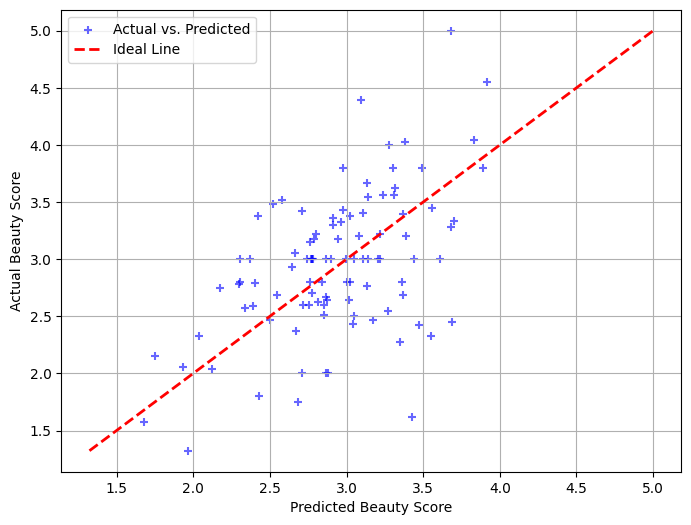

In [39]:
# Plotting y_true vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred,y_true, marker='+', color='blue', alpha=0.6, label='Actual vs. Predicted')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Add labels and title
plt.xlabel('Predicted Beauty Score')
plt.ylabel('Actual Beauty Score')
plt.legend()
plt.grid(True)
plt.savefig('effenenet.svg', dpi=600,bbox_inches='tight', pad_inches=0)